#### Basic example

In [9]:
import librosa

# get the filepath
filename = 'C:\\Users\\kipli\\Cedric\\Dance_of_the_Sugar_Plum_Fairy.ogg'

# load the file as a waveform 'y' and store the sampling rate as 'sr'
# y is a time series
y, sr = librosa.load(filename)

# run the default beat cracker
# beat_frames is an array of frame numbers with detected beat events
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

# convert the frame indices of beat events into time stamps (corresponding to detected beat events)
beat_times = librosa.frames_to_time(beat_frames, sr)

Estimated tempo: 107.67 beats per minute


#### Advanced Example

1. `librosa.effects.hpss()` separates `y` into two time series, containing the harmonic (tonal) and the percussive (transient) portions of the signal. Each portion has the same duration. The motivation for this kind of operation is two-fold: first, percussive elements tend to be stronger indicators of rhythmic content, and can help provide more stable beat tracking results; second, percussive elements can pollute tonal feature representations (such as chroma) by contributing energy across all frequency bands, so we’d be better off without them.
2. `librosa.feature.mfcc()` is used to extract the Mel-frequency cepstral coefficients of the MFC - a representation of the short-term energy spectrum of the raw signal. The output is a numpy array of shape `(n_mfcc, T)` (where T is the track duration in frames). The number of columns of mfcc is equal to the detected `beat_frames`
3. `librosa.feature.delta()` computes the smoothed first-order differences amoing the columns of the input. The output `mfcc_delta` has the same shape as the input `mfcc`.
4. `librosa.util.sync(np.vstack([mfcc, mfcc_delta]), beat_frames)` aggregates the columns of its inputs between sample indices. `mfcc` and `mfcc_delta` are vertically stacked together. The output is a matrix `beat_mfcc_delta` with the same number of rows as its input and number of columns depending on `beat_frames`. Each column `beat_mfcc_delta[:, k]` will be the average of input columns between `beat_frames[k]` and `beat_frames[k+1]`. (beat_frames will be expanded to span the full range `[0, T]` so that all data is accounted for.)
5. `librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)` computes a `chromagram`, which is a `(12, T)` numpy array with each row corresponding to a pitch class and each column normalized by its peak value. It is possible to alter this by setting a `norm` parameter.
6. `librosa.util.sync(chromagram, beat_frames, aggregate=np.median)` synchronizes the chroma between beat events. Any statistical summarization function can be used for the aggregation. 
7. A feature matrix is computed by stacking the synced chroma and `beat_mfcc_delta`.

In [9]:
import numpy as np
import librosa

# laod clip
filepath = 'C:\\Users\\kipli\\Cedric\\Dance_of_the_Sugar_Plum_Fairy.ogg'
y, sr = librosa.load(filepath)

# set the hop length ~23ms
hop_length = 512

# separate the harmonics and percussives into two waveforms
y_harmonic, y_percussive = librosa.effects.hpss(y)

# beat track the percussive signal
tempo, beat_frames = librosa.beat.beat_track(y_percussive, sr=sr)

# compute the MFCC features from the raw signal
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)
print(f'\nMFCC features: \n{mfcc}')

# first-order differences (delta features)
mfcc_delta = librosa.feature.delta(mfcc)
print(f'\nDelta features: \n{mfcc_delta}')

# stack and synchronize beat events
# here, we use the mean value (default) rather than the median
beat_mfcc_delta = librosa.util.sync(np.vstack([mfcc, mfcc_delta]), beat_frames)
print(f'\nSynced signal: \n{beat_mfcc_delta}')

# compute the chroma features from the harmonic signal
chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)
print(f'\nChroma features: \n{chromagram}')

# aggregate chroma features between beat events
# we'll use the median value of each feature
beat_chroma = librosa.util.sync(chromagram, beat_frames, aggregate=np.median)
print(f'\nAggregated chroma features: \n{beat_chroma}')

# stack all the beat_synchronous features together
beat_features = np.vstack([beat_chroma, beat_mfcc_delta])


MFCC features: 
[[-602.36005 -602.36005 -602.36005 ... -602.36005 -602.36005 -602.36005]
 [   0.         0.         0.      ...    0.         0.         0.     ]
 [   0.         0.         0.      ...    0.         0.         0.     ]
 ...
 [   0.         0.         0.      ...    0.         0.         0.     ]
 [   0.         0.         0.      ...    0.         0.         0.     ]
 [   0.         0.         0.      ...    0.         0.         0.     ]]

Delta features: 
[[ 4.7758025e-14  4.7758025e-14  4.7758025e-14 ... -6.2357583e-03
  -6.2357583e-03 -6.2357583e-03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.2735988e-03
  -3.2735988e-03 -3.2735988e-03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  6.3850912e-03
   6.3850912e-03  6.3850912e-03]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -6.9502019e-03
  -6.9502019e-03 -6.9502019e-03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -7.6169395e-03
  -7.6169395e-03 -7.6169395e-03]
 [ 0.0000000e+00  0.0

In [10]:
np.shape(mfcc)

(13, 5163)

#### Load a song

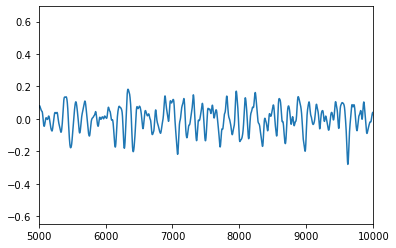

883055
Execution time: 0.41416215896606445 sec


In [70]:
import librosa
import time
from matplotlib import pyplot as plt

filepath = 'C:\\Users\\kipli\\Cedric\\speech_processing\\Beethoven_Moonlight_Sonata.ogg'
data, sr = librosa.load(filepath, sr=None, res_type='fft')

start = time.time()

samples = list(range(0, len(data)))

plt.plot(samples, data)
plt.xlim(5000, 10000)
plt.show()

print(len(data))
print(f"Execution time: {time.time()-start} sec")

### Mel Spectrogram

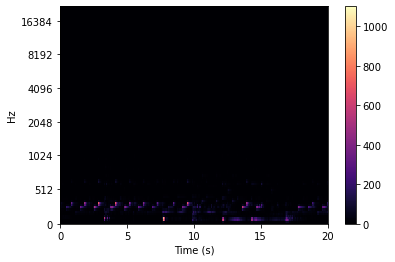

In [76]:
import librosa.display

spec = librosa.feature.melspectrogram(y=data, sr=sr)

# display the spectrogram in linear scale
librosa.display.specshow(spec, y_axis='mel', x_axis='s', sr=sr)

# display the color scale
plt.colorbar()
plt.show()

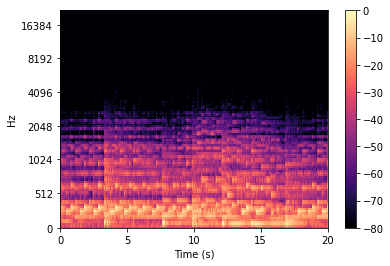

In [77]:
# mel spectrogram in dB
db_spec = librosa.power_to_db(spec, ref=np.max)
librosa.display.specshow(db_spec, y_axis='mel', x_axis='s', sr=sr)
plt.colorbar()
plt.show()

### Harmonic Percussive Separation

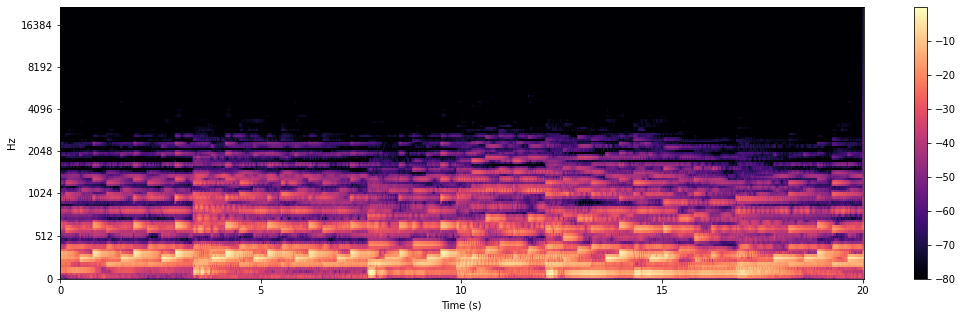

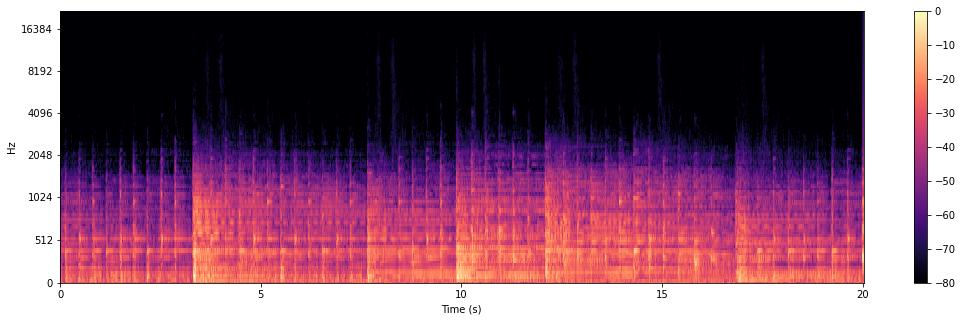

In [92]:
data_h, data_p = librosa.effects.hpss(data)

# spectrograms
spec_h = librosa.feature.melspectrogram(data_h, sr)
spec_p = librosa.feature.melspectrogram(data_p, sr)
db_spec_h = librosa.power_to_db(spec_h, ref=np.max)
db_spec_p = librosa.power_to_db(spec_p, ref=np.max)

# harmonic component in dB
plt.figure(figsize=(18,5))
librosa.display.specshow(db_spec_h, y_axis='mel', x_axis='s', sr=sr)
plt.colorbar()

# percussive component in dB
plt.figure(figsize=(18,5))
librosa.display.specshow(db_spec_p, y_axis='mel', x_axis='s', sr=sr)
plt.colorbar()
plt.show()

##### Now that the percussive features have been separated out, we can extract which pitches are present as notes from the harmonic features.

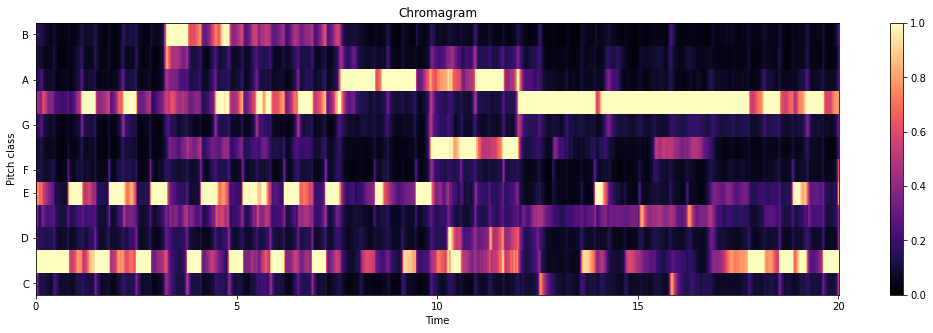

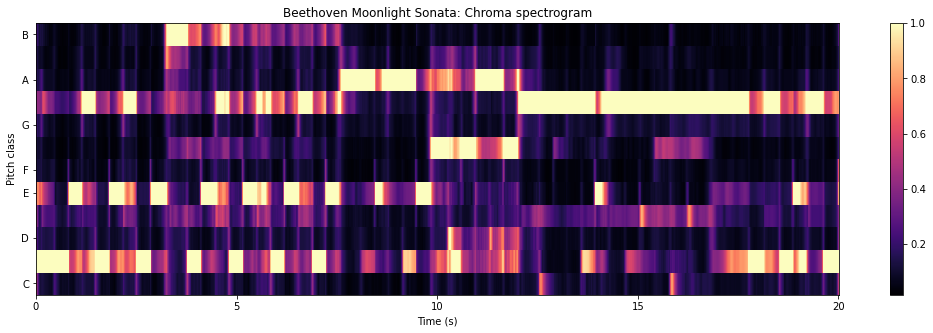

In [112]:
chroma = librosa.feature.chroma_cqt(y=data, sr=sr)

plt.figure(figsize=(18,5))
librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

plt.title("Chromagram")
plt.colorbar()
plt.show()

plt.figure(figsize=(18,5))
librosa.display.specshow(chroma, sr=sr, x_axis='s', y_axis='chroma')
plt.title("Beethoven Moonlight Sonata: Chroma spectrogram")
plt.colorbar()
plt.show()


### Playing an audio file

In [101]:
import IPython
IPython.display.Audio(data, rate=44100)

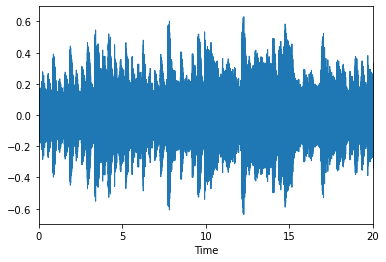

In [103]:
# You can also visualize the waveform using the waveform function
librosa.display.waveplot(data, sr=sr)

### Using the Short Time Fourier Transform (STFT)

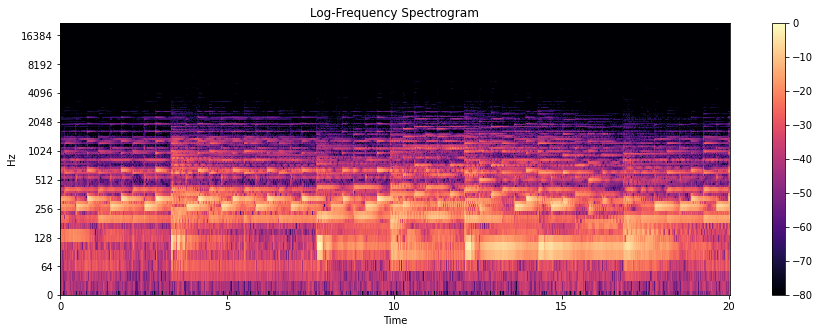

In [124]:
fdata = librosa.stft(data)
# now convert to dB
fdata_db = librosa.amplitude_to_db(abs(fdata), ref=np.max)

# plot the spectrogram
plt.figure(figsize=(15,5))
librosa.display.specshow(fdata_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.title("Log-Frequency Spectrogram")
plt.show()

### Creating an audio signal and saving it

In [140]:
import soundfile as sf
sr = 44100 # sample rate

T = 5.0 # duration in seconds
t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
x = 0.5*np.sin(2*np.pi*220*t) # sine wave at 220Hz

# play the audio
IPython.display.Audio(x, rate=sr)

# write to file
sf.write('generated.wav', x, sr, format='ogg', subtype='vorbis')

### Feature extraction from audio signals
#### Zero Crossing Rate

Number of zero crossings: 14


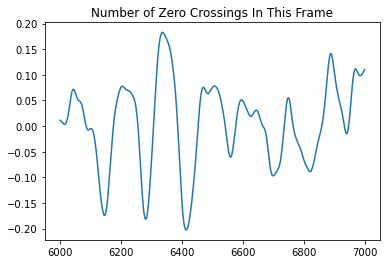

In [151]:
plt.plot(samples[6000:7000], data[6000:7000])
plt.title("Number of Zero Crossings In This Frame")
zero_crossings = librosa.zero_crossings(data[6000:7000], pad=False)
no = len([x for x in zero_crossings if x==True])
print(f'Number of zero crossings: {no}')

#### Spectral Rolloff

In [152]:
rolloff = librosa.feature.spectral_rolloff(data, sr)